## He II flash spectroscopy

In [22]:
import numpy as np
import pandas as pd
import extinction
from astropy.io import fits
from astropy.table import Table
import astropy.constants as const
from helper import phys
from helper.specread import get_keck, gaplinelist
from helper.readfilter import get_UVOT_eff_wave
from helper.specread import add_telluric_circle, pblines
from helper.specread import truncate_spec, measure_flux, gaus
from helper.app2abs import add_physcol, deredden_df, app2abs_df
from allsn_info import get_at2019dge
from scipy.interpolate import splrep, splev, interp1d

import matplotlib
import matplotlib.pyplot as plt
fs= 14
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

In [2]:
result = get_at2019dge()
z = result["z"]
ebv = result["ebv"]
ebv = result["ebv"]
t_max = result["t_max"]

In [3]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
D = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc

In [4]:
dt1 = get_keck(z=z, date = "20190412_Keck1_v2", vkernel = 200, t0jd = t_max, ebv = ebv)
knots = np.hstack([np.linspace(3700, 5700, 7), np.linspace(6000, 9500, 3)])

In [5]:
yaolist = gaplinelist(z=0)
H_list = yaolist['H_list']
HeII_list = yaolist['HeII_list']
OIII_list = yaolist['OIII_list']
NII_list = yaolist['NII_list']

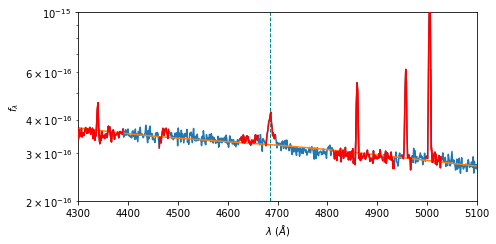

In [6]:
plt.figure(figsize=(7,3.5))
axi = plt.subplot(111)
axi.plot(dt1["wave_rest"], dt1["spec_obs0"])
plt.semilogy()
#plt.semilogx()
axi.set_xlabel(r"$\lambda$"+" ($\AA$)")
plt.xlim(4300, 5100)
axi.set_ylabel(r"$f_\lambda$")

wv_cont_, fl_cont_ = truncate_spec(dt1["wave_rest"], dt1["spec_obs0"], axi)

t,c,k = splrep(wv_cont_, fl_cont_, k=3, task=-1, t = knots)
flux_cont = splev(dt1["wave_rest"], (t,c,k)) 

axi.plot(dt1["wave_rest"], flux_cont)

tbottom = 2e-16
tup = 1e-15
plt.ylim(tbottom, tup)
pblines(axi, HeII_list, color='darkcyan', label="He II", tb = tbottom, tu = tup, ls = '--')
plt.tight_layout()

flux_line = dt1["spec_obs0"] - flux_cont

line width = 3.94 AA
line center is 4685.30 +- 0.30
line flux of HeII4686 is: 8.72 +- 0.69 1e-16


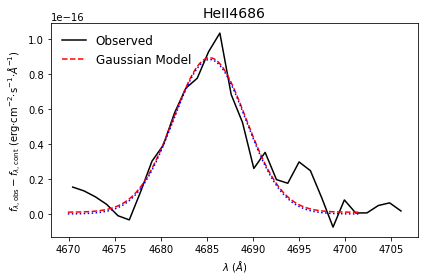

In [7]:
flux_HeII = measure_flux(dt1["wave_rest"], flux_line, line_center = HeII_list[0],  sigma_guess = 4,
                           line_left = 16, line_right = 21, 
                           line_bound_width = 1., linename = "HeII4686")

In [8]:
L_HeII = 4*np.pi*(const.pc.cgs.value * D)**2 * flux_HeII["flux"]
print (L_HeII)

8.975421937799783e+38


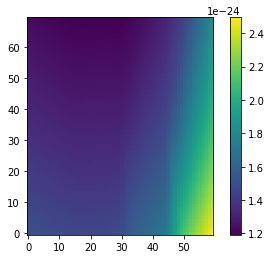

In [9]:
import pyneb as pn

# pn.atomicData.getDataFile()

He2 = pn.RecAtom('He', 2)

He2.labels[:10]

tem = np.linspace(9000, 11000, 70)
den = np.logspace(8, 12, 60)
im_HeII43 = He2.getEmissivity(tem, den, label='4_3') 

plt.figure()
plt.imshow(im_HeII43, origin = "lower left")
plt.colorbar()

In [10]:
A = He2.getEmissivity(1e+4, 1e+10, label='4_3') # consistent with KDE (2018)
A = float(A)
print (A)

1.32e-24


In [23]:
m_He = 2 * const.m_p.cgs.value

In [15]:
r_min = L_HeII * phys.sigma_T**2 / (2 * np.pi * A) 

In [19]:
print ("r_min", r_min / 1e+13, "1e+13 cm")

r_min 4.789227313084062 1e+13 cm


In [26]:
K2_min = r_min * L_HeII * m_He**2 / (8 * np.pi * A)

In [27]:
K_min = np.sqrt(K2_min)

In [32]:
print ("K_min", K_min / 1e+14, "1e+14")

K_min 1.204151250024072 1e+14


In [33]:
MHe_min = 4 * np.pi * K_min * r_min

In [38]:
print ("min He mass", MHe_min / phys.sm, "Msun")

min He mass 3.6444846851465504e-05 Msun


In [39]:
phys.h

6.62607004e-27